In [1]:
# Import Packages
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import quantstats as qs
import os
import ipynb_path
import itertools
import time

# Uncomment to install technical analysis package
#!pip install ta
import ta

# Allow Multiple Outputs in Cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Utility and Helper Methods

# Method to compute the 'start date' given and end date and a 'time period in years', which can be fractional
def compute_start_date(end_date, time_period_in_years):
    return datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days=365 * time_period_in_years)

end_date = "2025-06-01"
time_period = 1.5
start_date = compute_start_date(end_date, time_period)

# Function Test
print('Example: Compute_start_date Method')
print('=' * 50)
print(f'Start date: {start_date} \nThis is {time_period:.2f} year(s) before the given end date {end_date}')

Example: Compute_start_date Method
Start date: 2023-12-01 12:00:00 
This is 1.50 year(s) before the given end date 2025-06-01


In [3]:
# Data Manager Class
class DataManager():
    
    # Constructor
    def __init__(self, symbols, start_date, end_date, window=30, source='YF', xl_workbook=None, sheet_name=None):
        
        # Initialize Class Member Variables
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        self.window = window
        self.source = source
        self.xl_workbook = xl_workbook
        
        # Load Data
        self.df = self.load_data(symbols, start_date, end_date, source, xl_workbook, sheet_name)
        
        # Compute and Append the Spread
        self.compute_and_append_spread(self.window)
        
        # Test if Spread Data is Stationary and store the result
        self.is_stationary = self.stationarity_test()

    # Load data from YF=Yahoo Finance or XL=Excel File
    def load_data(self, symbols, start_date, end_date, source='YF', xl_workbook=None, sheet_name=None):
        
        # Data Source = Yahoo Finance
        if (source.casefold() == 'YF'.casefold()): # ( casefold = case insensitive string compare)
            return self.download_yahoo(symbols, start_date, end_date)
        
        elif (source.casefold() == 'XL'.casefold()): # ( casefold = case insensitive string compare)
            return self.import_excel_data(xl_workbook, sheet_name, start_date, end_date)
            
        # Default Data Source = Yahoo Finance
        else:
            return self.download_yahoo(symbols, start_date, end_date)
        
    # Download data from yahoo finance
    def download_yahoo(self, symbols, start_date, end_date):
        print('Downloading Data from Yahoo Finance')
        result = yf.download(symbols, start=start_date, end=end_date, progress=False)
        return result
    
    # Method to import data from an Excel Workbook file
    def import_excel_data(self, xl_workbook, sheet_name, start_date, end_date):

        # Return nothing if no path or sheet name
        if (xl_workbook == None or sheet_name == None):
            return
        
        # Set XL File Path relative to the current python notebook
        active_folder = os.path.dirname(ipynb_path.get())
        xl_file_path = active_folder + '\\' + xl_workbook

        # import data
        df = pd.read_excel(xl_file_path, sheet_name=sheet_name)

        # filter data to match our choosen date range
        filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

        # set date column as index
        filtered_df.set_index('date', inplace=True)

        print('Imported data from Excel')
        return filtered_df
    
    # Export DataFrame to Excel
    def export_to_excel(self, file_name='BackTest.xlsx'):
        self.df.to_excel(file_name, index=True)
        print(f'Exported to Excel File {file_name}')
    
    # Compute and Append the Spread, note: window controls the mean and std period in days (defaults to 30 days)
    # When use_cash_hedge = true (hedge change in prices) and for False we use a qty hedge (hedge change in % returns)
    def compute_and_append_spread(self, window=30, use_cash_hedge=False, hedge_window=90):
    
        # Copy the class data
        df = self.df.copy()
        
        # The spread order is the order is controlled by the order of the security symbols entered
        # We compute spread using price[0] - price[1] i.e. first symbol for Y and second for X
        price_Y = df.iloc[:, 0]
        price_X = df.iloc[:, 1]
        
        # Hedge Ratio: Can be a Cash Hedge (price based) or Performance Hedge (returns based)
        # ================================================
        # Spreads using cash hedges are more likely to be stationary with spreads that hover around zero as cash prices are being hedged
        # Spread using performance hedges are unlie
        #
        # Price data gives a hedge ratio in cash units
        # Returns data computes a hedge ratio in asset units

        if use_cash_hedge:
            
            # HEDGE PRICES
            # ------------
            
            price_X_with_constant = price_X
            price_X_with_constant = sm.add_constant(price_X)
            
            # Compute the hedge ratio using Ordinary Least Squares regression (OLS)
            # Use front period hedge window for OLS to avoid look-ahead bias
            model = sm.OLS(price_Y[:hedge_window], price_X_with_constant[:hedge_window])
            model = model.fit() 
        
            # For OLS slope (hedge ratio) use params[1] when using a constant and o.w. params[0]
            hedge_ratio = model.params[1]
            
            # SPREAD using PRICES
            # --------------------
            
            # Compute the Spread using Prices and Price Hedge Ratio
            df['spread'] = price_Y - hedge_ratio * price_X
            
        else:
        
            # HEDGE RETURNS
            # -------------
            
            # Take log returns of the prices to compute the hedge ratio in units of underlying rather than as cash amount units
            log_returns_Y = np.log(price_Y / price_Y.shift(1))
            log_returns_X = np.log(price_X / price_X.shift(1))
        
            # Drop the first row with NaN values
            log_returns_Y = log_returns_Y.dropna()
            log_returns_X = log_returns_X.dropna()

            # Add a constant
            log_returns_X_with_constant = log_returns_X
            log_returns_X_with_constant = sm.add_constant(log_returns_X)
        
            # Compute the hedge ratio using Ordinary Least Squares regression (OLS)
            # Use front period hedge window for OLS to avoid look-ahead bias
            model = sm.OLS(log_returns_Y[:hedge_window], log_returns_X_with_constant[:hedge_window])
            model = model.fit() 
        
            # For OLS slope (hedge ratio) use params[1] when using a constant and o.w. params[0]
            hedge_ratio = model.params[1]
            
            # SPREAD using RETURNS
            # --------------------
            
            # Compute the Spread using Returns and Returns Hedge Ratio
            #df['spread'] = log_returns_Y - hedge_ratio * log_returns_X
            df['spread'] = price_Y - hedge_ratio * price_X
        
        
        # Calculate the mean and standard deviation
        # -----------------------------------------
        
        # SIMPLE MOVING AVERAGE (Uncomment to use)
        # df['mean'] = df['spread'].rolling(window=window).mean()

        # Exponentially Weighted Moving Average (EWM)
        df['mean'] = df['spread'].ewm(span=window, adjust=False).mean()
        df['std'] = df['spread'].rolling(window=window).std()
        
        # -----------------------------------------
        
        # Compute Spread Returns
       
        # SPREAD LOG RETURNS
        # ------------------
        df['spread_returns'] = np.log(df['spread']/df['spread'].shift(1))
        df['spread_returns'][0] = 0
        
        # Handle Negative Spreads - Take Absolute Value of Denominator to get Returns Sign Correct
        df['spread_returns'] = np.where( df['spread'] < 0, np.log(df['spread']/abs(df['spread'].shift(1))), df['spread_returns'] )
        # ---------------------
        
        # SPREAD SIMPLE RETURNS
        # ---------------------
        #df['spread_returns'] = ( df['spread'] - df['spread'].shift(1) ) / df['spread'].shift(1)
        #df['spread_returns'][0] = 0
        
        # Handle Negative Spreads - Take Absolute Value of Denominator to get Returns Sign Correct
        #df['spread_returns'] = np.where( df['spread'] < 0, ( df['spread'] - df['spread'].shift(1) ) / abs(df['spread'].shift(1)), df['spread_returns'] )
        # ---------------------
        
        # Handle Zero Spreads - When Returns Denominator i.e. shift(1) is zero the Return Formula Explodes so set these to zero
        # Zero spread is our exit point so I guess returns in this case could be assumed negligible
        df['spread_returns'] = np.where( df['spread'].shift(1) == 0, 0, df['spread_returns'] )
        
        # Some spreads will be zero, when dividing by zero for returns this will give 'infinity' (inf) as the result
        # Here we replace +/- inf with not a number (nan) and then replace this nan with a zero value
        df['spread_returns'] = df['spread_returns'].replace([np.inf, -np.inf], np.nan)
        df['spread_returns'] = df['spread_returns'].fillna(0)
        
        # Update class data
        self.df = df.copy()

    # Method to test for stationarity using the Augmented Dickey-Fuller Test
    def stationarity_test(self, tolerance=0.05):
        
        # Perform Dickey-Fuller test
        result = adfuller(self.df['spread'])
        p_value = result[1]

        # Test if p-value < tolerance
        is_stationary = p_value < tolerance
        message = 'is Stationary' if is_stationary else '*** Not *** Stationary'
        print(f'Spread Series {message} (p-value {p_value*100:.2f}% < tolerance {tolerance*100:.2f}%)')
        
        return is_stationary
        
    # Display Data
    def display(self, rows=5, head_or_tail='head'):
        
        if (head_or_tail=='head'.casefold()): # casefold = case insensitive string compare
            return self.df.head(rows)
        else:
            return self.df.tail(rows)
                     
    # Plot Prices
    def plot_prices(self, column_name='Close'):
        
        if self.source=='XL':
            column_name = self.symbols
        
        df = self.df if (column_name==None) else self.df[column_name]
        plt.figure(figsize=(10,4))
        
        # Plot each symbol
        for symbol in df.columns:
            plt.plot(df.index, df[symbol], label=symbol)

        plt.title('Price')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()
        
    # Plot Spreads
    def plot_spreads(self):

        plt.figure(figsize=(10, 4))
        plt.plot(self.df.index, self.df['spread'], label='spread', color='red')
        plt.plot(self.df.index, self.df['mean'], label='mean', color='black', linestyle='--')
    
        plt.title('spread')
        plt.xlabel('date')
        plt.ylabel('spread')
        plt.legend()
        plt.show()

In [4]:
# BackTestPair Class - Inherits from DataManager Class
class BackTestPair(DataManager):
    
    # Constructor
    def __init__(self, symbols, start_date, end_date, window=60, num_std_up = 1.0, num_std_down = 1.0, source='YF', xl_workbook=None, sheet_name=None):
        
        print(f'\nRunning Trading Strategy for {symbols}')
        print('*' * 50)
        
        # Initialize Data Manager Parent Class
        super().__init__(symbols, start_date, end_date, window, source, xl_workbook, sheet_name)
        
        # Store Any Additional Parameters
        self.num_std = (num_std_up + num_std_down) * 0.5
        self.num_std_up = num_std_up
        self.num_std_down = num_std_down
        
        # Compute Feature Data and Append to DataFrame
        self.apply_feature_data()
        
        # Run the Trading Strategy and Measure Performance
        self.run_trading_strategy()
        self.strategy_statistics()
        
    def apply_feature_data(self):
        
        # Copy the underlying data
        df = self.df.copy()
        
        # Z-Scores and Z-Score Bands - scaled by no. of std deviations (num_std)
        df['z_score'] = (df['spread'] - df['mean']) / (self.num_std * df['std'])
        df['z_upper1'] = + 1.0 * self.num_std_up
        df['z_upper2'] = + 2.0 * self.num_std_up
        df['z_lower1'] = - 1.0 * self.num_std_down
        df['z_lower2'] = - 2.0 * self.num_std_down
        
        # Bollinger Bands - scaled by no. of std deviations (num_std)
        df['bb_upper1'] = df['mean'] + (1.0 * self.num_std_up * df['std'])
        df['bb_upper2'] = df['mean'] + (2.0 * self.num_std_up * df['std'])
        df['bb_lower1'] = df['mean'] - (1.0 * self.num_std_down * df['std'])
        df['bb_lower2'] = df['mean'] - (2.0 * self.num_std_down * df['std'])
    
        # Update class data
        self.df = df.copy()
        
     # Method to plot the z-scores and the underlying spread
    def plot_z_scores(self, show_spread=True):
    
        if show_spread:
            
            # SHOW SPREAD
            # -----------
            
            # Plot the Z-Scores and the Underlying Spread
            fig, ax = plt.subplots(figsize=(10,4))

            # first axis
            ax.plot(self.df.index, self.df['z_score'], color='green')
            ax.plot(self.df.index, self.df['z_upper2'], color='green')
            ax.plot(self.df.index, self.df['z_lower2'], color='green')
            ax.set_ylabel('Z-score', color='green')
            
            # Zero Standard Deviation Line
            plt.axhline(y=0, color='black', linestyle='--')
            
            # second axis
            ax1 = ax.twinx()
            ax1.plot(self.df.index, self.df['spread'], color='red', alpha=0.7)
            ax1.set_ylabel('Spread', color='red')

            plt.title('Z-Scores & Spread')
            plt.show();
        
        else:
            
            # DON'T SHOW SPREAD
            # -----------------
            
            # Plot Z-Scores without Underlying Spread
            plt.figure(figsize=(10, 4))
            plt.plot(self.df.index, self.df['z_score'], label='z_score', color='green')
    
            # Zero Standard Deviation Line
            plt.axhline(y=0, color='black', linestyle='--')
    
            plt.plot(self.df.index, self.df['z_upper2'], label='z_upper2', color='green', alpha=0.7)
            plt.plot(self.df.index, self.df['z_lower2'], label='z_lower2', color='green', alpha=0.7)
    
            plt.title('z_score')
            plt.xlabel('date')
            plt.ylabel('z_score')
            plt.legend()
            plt.show()
        
    # Method to plot the spread, mean and bollinger bands
    def plot_bollinger_bands(self):

        plt.figure(figsize=(10, 4))
        plt.plot(self.df.index, self.df['spread'], label='spread', color='red')
        plt.plot(self.df.index, self.df['mean'], label='mean', color='black', linestyle='--')

        plt.plot(self.df.index, self.df['bb_upper1'], label='bb_upper1', color='green')
        plt.plot(self.df.index, self.df['bb_upper2'], label='bb_upper2', color='blue')

        plt.plot(self.df.index, self.df['bb_lower1'], label='bb_lower1', color='green')
        plt.plot(self.df.index, self.df['bb_lower2'], label='bb_lower2', color='blue')

        plt.title('Bollinger Bands')
        plt.xlabel('date')
        plt.ylabel('spread')

        plt.legend()
        plt.show()
        
    # Method to run the strategy and update trading positions using the feature data to define trade entry and exit points
    def run_trading_strategy(self):
        
        # Copy the class data
        df = self.df.copy()
   
        # Initialize Signal and Position Data
        df['signal'] = 0
        df['position'] = 0
                
        # ENTRY SIGNALS - Using Vectorization for Speed
        # =============
        
        # Check for cross-over, but also check cross-over does not jump from lower2 beyond lower1
        long_entry_condition = ((df['z_score'].shift(1) < df['z_lower2']) 
                                & (df['z_score'] > df['z_lower2'])
                                & (df['z_score'] < df['z_lower1']))
        
        # Check for cross-over, but also check cross-over does not jump from upper2 beyond upper1
        short_entry_condition = ((df['z_score'].shift(1) > df['z_upper2'])
                                & (df['z_score'] < df['z_upper2'])
                                & (df['z_score'] > df['z_upper1']))
        
        # LONG ENTRY
        df.loc[long_entry_condition, 'signal'] = 1
        
        # SHORT ENTRY
        df.loc[short_entry_condition, 'signal'] = -1
        
        # EXIT SIGNALS - Using a Simple Loop with No Vectorization due to Data Dependencies
        # ============
        
        current_position = 0

        # Iterate over the data frame by numeric index, despite the data frame having a date index
        # We skip the first index, since too early to exit a position
        for i in range(1, len(df)):
                        
            # Update Current Position Based on the Underlying Signal
            if (current_position == 0):
                current_position = 1 if (df['signal'].iloc[i] == 1) else -1 if (df['signal'].iloc[i] == -1) else current_position
            
            # Skip the the Current Position is Flat i.e. Zero
            if (current_position == 0):
                continue
            
            # LONG EXIT (TAKE PROFIT)
            if ((current_position == 1) and ((df['z_score'].iloc[i-1] < 0) and (df['z_score'].iloc[i] > 0))):
                df.loc[df.index[i], 'signal'] = -1
                current_position = 0
                
            # LONG EXIT (STOP LOSS)
            if ((current_position == 1) and ((df['z_score'].iloc[i-1] > df['z_lower2'].iloc[i]) and (df['z_score'].iloc[i] < df['z_lower2'].iloc[i]))):
                df.loc[df.index[i], 'signal'] = -1
                current_position = 0
                
            # SHORT EXIT (TAKE PROFIT)
            if ((current_position == -1) and ((df['z_score'].iloc[i-1] > 0) and (df['z_score'].iloc[i] < 0))):
                df.loc[df.index[i], 'signal'] = 1
                current_position = 0
                
            # SHORT EXIT (STOP LOSS)
            if ((current_position == -1) and ((df['z_score'].iloc[i-1] < df['z_upper2'].iloc[i]) and (df['z_score'].iloc[i] > df['z_upper2'].iloc[i]))):
                df.loc[df.index[i], 'signal'] = 1
                current_position = 0
                
        # UPDATE POSITION
        df['position'] = df['signal'].cumsum()
        
        # Close-out final position for accurate back-testing reporting
        df['position'].iloc[-1] = 0

        # Update class data
        self.df = df.copy()
        return
        
    # Plot Trade Positions, Entry and Exit Points
    def plot_trade_positions(self):
    
        fig, ax1 = plt.subplots(figsize=(10, 4))
        
        # first axis
        ax1.plot(self.df.index, self.df['spread'], label='spread', color='red')
        ax1.set_xlabel('date')
        ax1.set_ylabel('spread', color='red')
        
        # second axis
        ax2 = ax1.twinx()
        ax2.plot(self.df.index, self.df['position'], label='position', color='green')
        ax2.set_ylabel('position', color='green')
        ax2.set_yticks([-1, 0, 1])
        ax2.set_yticklabels(['Sell','Neutral','Buy'])

        plt.title('Trade Positions')
        plt.show()

    # Compute the Trading Strategy Statistics
    def strategy_statistics(self, risk_free_rate=0.0):
        
        # Strategy Returns (Needed for Tear-Sheets)
        # ----------------
        
        # Strategy Return is the Spread Return scaled by the Position direction 
        # Note: We can't trade close positions until the following day, so shift by one
        self.df['strategy_returns'] = self.df['spread_returns'] * self.df['position'].shift(1)

        # Finally fill any blanks with zero
        self.df['strategy_returns'] = self.df['strategy_returns'].fillna(0)
        
        # Sharpe Ratio
        # ------------
        
        days = 252
        
        self.strategy_mean = self.df['strategy_returns'].mean() * days - risk_free_rate
        self.strategy_std = self.df['strategy_returns'].std() * (days ** 0.5) # Annualize using sqrt of time
        
        self.sharpe_ratio = self.strategy_mean / self.strategy_std
        print(f'Sharpe Ratio {self.sharpe_ratio:.2f}')
        
        # Max Drawdown
        # ------------

        df = self.df.copy()
        df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()
        df['cum_max'] = df['cumulative_returns'].cummax()
        df['drawdown'] = (df['cumulative_returns'] - df['cum_max']) / df['cum_max']
        self.max_drawdown = df['drawdown'].min() * 100
        print(f'Max Drawdown: {self.max_drawdown:.2f}%')
        
    # Print the trading strategy tear sheet using QuantStats
    def tear_sheet(self, risk_free_rate=0.0):
        
        # Generate analytics using the QuantStats library
        qs.reports.basic(self.df['strategy_returns'], risk_free=risk_free_rate)


Running Trading Strategy for ['AAPL', 'AMZN']
**************************************************
Spread Series *** Not *** Stationary (p-value 18.86% < tolerance 5.00%)
Sharpe Ratio 1.07
Max Drawdown: -7.08%


                    Strategy
------------------  ----------
Start Period        2024-07-01
End Period          2025-06-30
Risk-Free Rate      0.0%
Time in Market      29.0%

Cumulative Return   18.86%
CAGR﹪              12.71%

Sharpe              1.07
Prob. Sharpe Ratio  85.63%
Sortino             1.66
Sortino/√2          1.17
Omega               1.39

Max Drawdown        -7.08%
Longest DD Days     44

Gain/Pain Ratio     0.39
Gain/Pain (1M)      -

Payoff Ratio        1.11
Profit Factor       1.39
Common Sense Ratio  1.85
CPC Index           0.86
Tail Ratio          1.33
Outlier Win Ratio   13.19
Outlier Loss Ratio  2.67

MTD                 -0.08%
3M                  10.71%
6M                  18.36%
YTD                 18.36%
1Y                  18.86%
3Y (ann.)           12.71%
5Y (ann.)           12.71%
10Y (ann.)          12.71%
All-time (ann.)     12.71%

Avg. Drawdown       -3.01%
Avg. Drawdown Days  8
Recovery Factor     2.66
Ulcer Index         0.02
Serenity Index      3.89


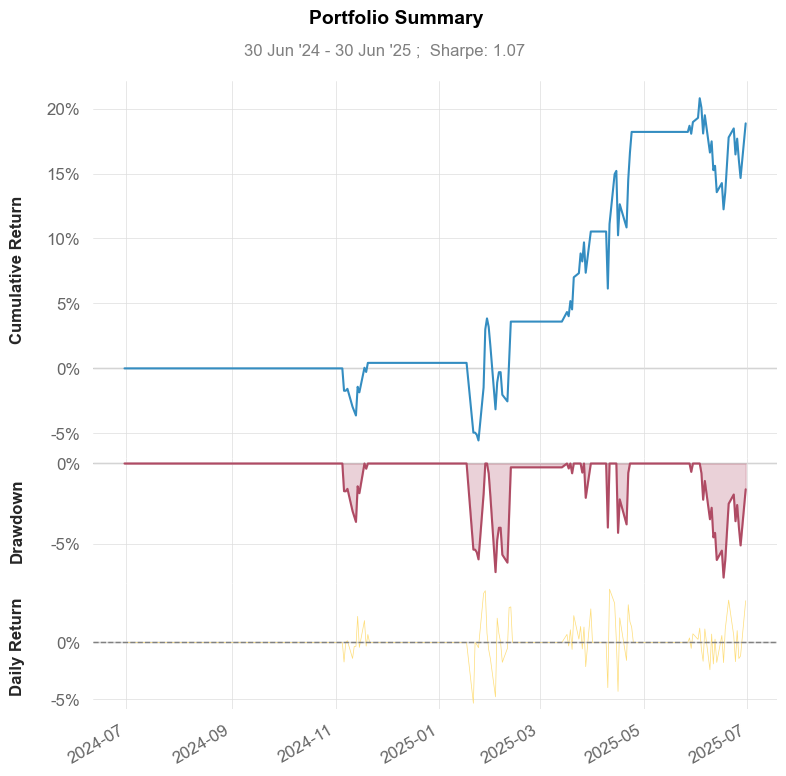

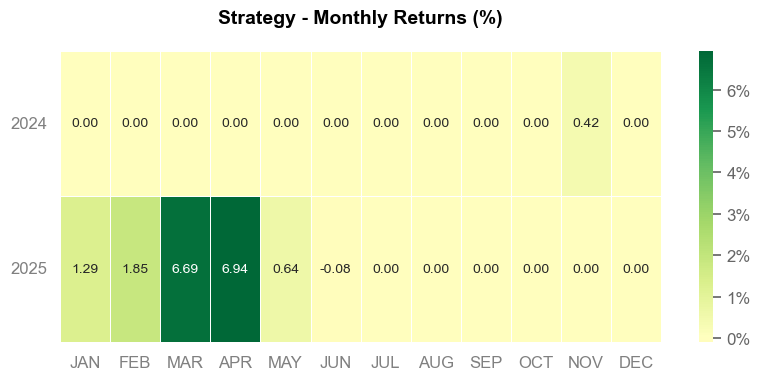

In [9]:
# Test the BackTest class and methods

# Yahoo Finance - Equity Pairs
# ---------------------------------------------
# Code vs Pepsi:       ['KO', 'PEP']
# Microsoft vs Google: ['MSFT','GOOG']
# Apple vs Amazon:     ['AAPL','AMZN']

AAPL = 'AAPL'
AMZN = 'AMZN'
symbols = [AAPL, AMZN]

# Back Test Parameters
# ---------------------------------------------
end_date = "2025-07-01"
back_test_period_in_years = 1.0
start_date = compute_start_date(end_date, back_test_period_in_years)
window = 30
num_std_up = 1.0
num_std_down = 1.0

# Data Source
# ---------------------------------------------
# Source: 'YF'=Yahoo Finance and 'XL'=Excel Workbook
source = 'YF'
xl_workbook = 'equity_data.xlsx'
sheet_name = 'equity'

# Run Back Test
# ---------------------------------------------
myPair = BackTestPair(symbols, start_date, end_date, window, num_std_up, num_std_down, source, xl_workbook, sheet_name)

# Strategy Analysis (Uncomment to Use)
# ---------------------------------------------
#myPair.display(rows=5, head_or_tail='head')
#myPair.plot_prices(column_name='Close')
#myPair.plot_spreads()
#myPair.plot_bollinger_bands()
#myPair.plot_z_scores()
#myPair.plot_trade_positions()
myPair.tear_sheet()
#myPair.export_to_excel('BackTest.xlsx')


Running Trading Strategy for ['USDCAD=X', 'EURGBP=X']
**************************************************
Spread Series *** Not *** Stationary (p-value 5.00% < tolerance 5.00%)
Sharpe Ratio 0.44
Max Drawdown: -1.19%


                    Strategy
------------------  ----------
Start Period        2024-12-30
End Period          2025-06-30
Risk-Free Rate      0.0%
Time in Market      19.0%

Cumulative Return   0.59%
CAGR﹪              0.82%

Sharpe              0.44
Prob. Sharpe Ratio  61.96%
Sortino             0.57
Sortino/√2          0.4
Omega               1.2

Max Drawdown        -1.19%
Longest DD Days     18

Gain/Pain Ratio     0.2
Gain/Pain (1M)      -

Payoff Ratio        0.85
Profit Factor       1.2
Common Sense Ratio  4.08
CPC Index           0.6
Tail Ratio          3.41
Outlier Win Ratio   16.66
Outlier Loss Ratio  1.99

MTD                 0.08%
3M                  0.15%
6M                  0.59%
YTD                 0.59%
1Y                  0.59%
3Y (ann.)           0.82%
5Y (ann.)           0.82%
10Y (ann.)          0.82%
All-time (ann.)     0.82%

Avg. Drawdown       -0.38%
Avg. Drawdown Days  4
Recovery Factor     0.51
Ulcer Index         0.0
Serenity Index      0.83


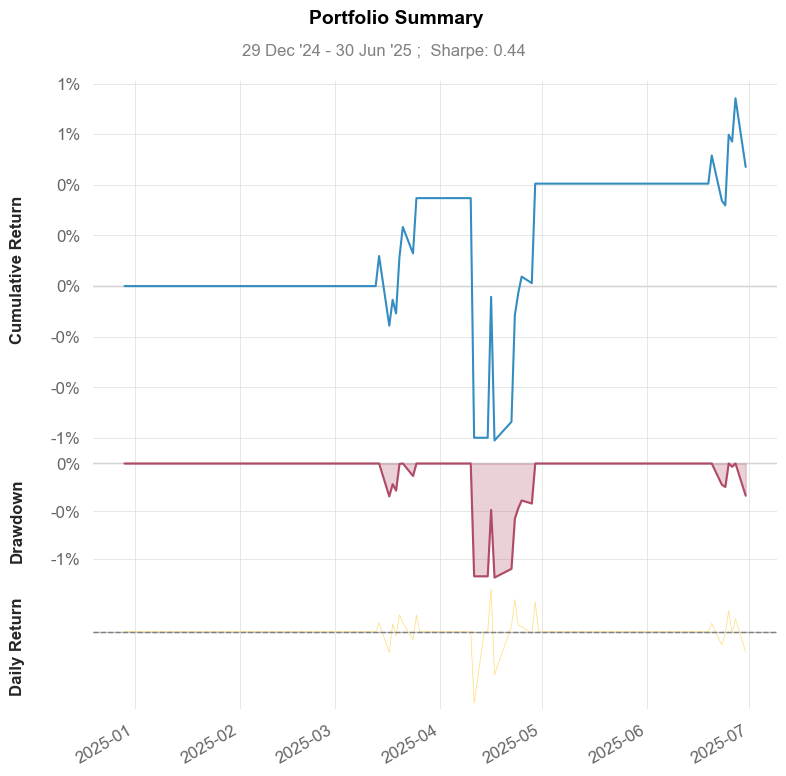

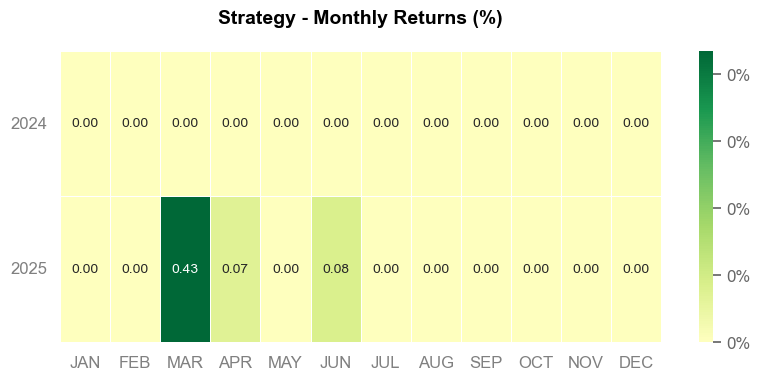

In [13]:
# FX Example
fx_pairs = ["USDCAD=X",'EURGBP=X']

end_date = "2025-07-01"
back_test_period_in_years = 0.5
start_date = compute_start_date(end_date, back_test_period_in_years)

window = 30
num_std = 1.0

myPair = BackTestPair(fx_pairs, start_date, end_date, window, num_std)

# Strategy Analysis (Uncomment to Use)
# ---------------------------------------------
#myPair.display(rows=5, head_or_tail='head'
#myPair.plot_prices(column_name='Close')
#myPair.plot_spreads()
#myPair.plot_bollinger_bands()
#myPair.plot_z_scores()
#myPair.plot_trade_positions()
myPair.tear_sheet()
#myPair.export_to_excel('BackTest.xlsx')